# EM - алгоритм

Загрузим необходимые библиотеки.

In [1]:
import numpy as np
from numpy.linalg import slogdet, det, solve
import matplotlib.pyplot as plt
import time
from sklearn.datasets import load_digits
%matplotlib inline

## EM для GMM

Исходные данные для модели:

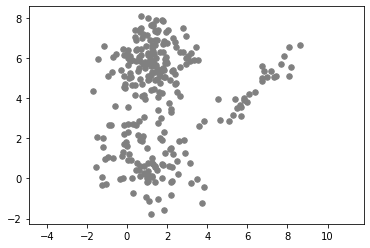

In [2]:
samples = np.load('samples.npz')
X = samples['data']
#pi0 = samples['pi0']
mu0 = samples['mu0']
sigma0 = samples['sigma0']
plt.scatter(X[:, 0], X[:, 1], c='grey', s=30)
plt.axis('equal')
plt.show()

### EM 

EM-алгоритм представляет собой оптимизацию нижней границы. $\mathcal{L}(\theta, q) = \int q(T) \log\frac{p(X, T|\theta)}{q(T)}dT\to \max$.

<b>E-step</b>:<br>
$\mathcal{L}(\theta, q) \to \max\limits_{q} \Leftrightarrow \mathcal{KL} [q(T) \,\|\, p(T|X, \theta)] \to \min \limits_{q\in Q} \Rightarrow q(T) = p(T|X, \theta)$<br>
<b>M-step</b>:<br> 
$\mathcal{L}(\theta, q) \to \max\limits_{\theta} \Leftrightarrow \mathbb{E}_{q(T)}\log p(X,T | \theta) \to \max\limits_{\theta}$

Для GMM, $\theta$ это набор параметров: математические ожидания $\mu_c$, ковариационные матрицы $\Sigma_c$ и априорное распределение  $\pi_c$ для каждой компоненты.

Cкрытые переменные $T$ — это индексы компонентов, которым соответствует каждая точка данных, т. е. $t_i$ — индекс кластера для объекта $x_i$.

Совместное распределение: 
$$
\log p(X, T \mid \theta) =  \sum\limits_{i=1}^N \log p(x_i, t_i=c \mid \theta) = \sum\limits_{i=1}^N \log \pi_c \, f_{\!\mathcal{N}}(x_i \mid \mu_c, \Sigma_c),$$
где $f_{\!\mathcal{N}}(x \mid \mu_c, \Sigma_c) = \frac{1}{\sqrt{(2\pi)^n|\boldsymbol\Sigma_c|}}
\exp\left(-\frac{1}{2}({x}-{\mu_c})^T{\boldsymbol\Sigma_c}^{-1}({x}-{\mu_c})
\right)$ плотности нормального з.р. $\mathcal{N}(x_i \mid \mu_c, \Sigma_c)$.

### E-step
На этом шаге нам нужно оценить апостериорное распределение по скрытым переменным с фиксированными значениями параметров: $q_i(t_i) = p(t_i \mid x_i, \theta)$. Мы предполагаем, что $t_i$ равен кластерному индексу истинной компоненты объекта $x_i$. Для этого нам нужно вычислить $\gamma_{ic} = p(t_i = c \mid x_i, \theta)$. Обратите внимание, что $\sum\limits_{c=1}^C\gamma_{ic}=1$. 


$$
\gamma_{ic} = p(t_i = c \mid x_i, \theta) = \frac{p(x_i\mid t_i=c,\theta) p(t_i=c\mid\theta)}{Z} = \frac{f_{\cal N}(x_i\mid \mu_c,\Sigma_c)\pi_c}{Z} = \frac{1}{Z\sqrt{(2\pi)^n|\boldsymbol\Sigma_c|}}
\exp\left(-\frac{1}{2}({x}-{\mu_c})^T{\boldsymbol\Sigma_c}^{-1}({x}-{\mu_c})
\right)\pi_c
$$
где $Z$ -  нормировочная константа.
$$
Z = \sum_c p(x_i\mid t_i=c,\theta) p(t_i=c\mid\theta)
$$

<b>Важный трюк 1:</b> важно избегать числовых ошибок. В какой-то момент вам придется вычислить формулу следующего вида: $\frac{e^{y_i}}{\sum_j e^{y_j}}$, которая называется _softmax_. Когда вы вычисляете показатели степени больших чисел, некоторые числа могут стать бесконечными. Этого можно избежать, разделив числитель и знаменатель на $e^{\max(y)}$: 
$$
\frac{e^{y_i-\max(y)}}{\sum_j e^{y_j - \max(y) )}}.
$$ 
После этого преобразования максимальное значение в знаменателе будет равно единице. Все остальные члены будут вносить меньшие значения. Итак, чтобы вычислить нужную формулу, вы сначала вычитаете максимальное значение из каждой компоненты в векторе $\mathbf{y}$, а затем вычисляете все остальное, как и раньше.

<b>Важный трюк 2:</b> в какой-то момент вам, вероятно, понадобится вычислить формулу вида $A^{-1}x$. Обычно вы инвертируете $A$, а затем умножаете его на $x$. Немного более быстрый и численно более точный способ сделать это — напрямую решить уравнение $Ay = x$ с помощью специальной функции. Его решение есть $y=A^{-1}x$, но уравнение $Ay = x$ можно решить методами, не обращающими явно матрицу. Для этого вы можете использовать ```np.linalg.solve```.

<b>Другие полезные функции: </b> <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.slogdet.html">```slogdet``` </a> и <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.det.html#numpy.linalg.det">```det``` </a>

## Реализация E-шаг

In [3]:
def calc_norm_pow(x, mu, sigma):    
    y = x - mu
    u = np.linalg.solve(sigma, y)
    return u.dot(y)/2

def norm_prob(sigma, norm_pow, y_max):
    d = sigma.shape[0]
    const = 1/((2*np.pi)**(d/2)*np.sqrt(np.linalg.det(sigma))) 

    return const*np.exp(-norm_pow + y_max)
        

def E_step(X, pi, mu, sigma):
    """
    Performs E-step on GMM model
    Each input is numpy array:
    X: (N x d), data points
    pi: (C), mixture component weights 
    mu: (C x d), mixture component means
    sigma: (C x d x d), mixture component covariance matrices
    
    Returns:
    gamma: (N x C), probabilities of clusters for objects
    """
    N = X.shape[0] # number of objects
    C = pi.shape[0] # number of clusters
    d = mu.shape[1] # dimension of each object
    gamma = np.zeros((N, C)) # distribution q(T)
    
    norm_pow = np.zeros((N,C))#gamma[:,:] = p(np.arange(C), X, (pi, mu, sigma))
    for i in range(C):
        for j in range(N):
            norm_pow[j,i] = calc_norm_pow(X[j,:], mu[i,:].T, sigma[i,:,:])
    y_max = np.max(norm_pow, axis=1)
    for i in range(C):
        for j in range(N):
            gamma[j,i] = norm_prob(sigma[i,:,:], norm_pow[j,i], y_max[j])*pi[i]
    den = np.sum(gamma, axis=1)
    #print(den.shape)
    for i in range(C):
        gamma[:,i] = gamma[:,i]/den
    return gamma

## M-шаг

На M-шаге нам нужно максимизировать $\mathbb{E}_{q(T)}\log p(X,T | \theta)$ по $\theta$. В нашей модели это означает, что нам нужно найти оптимальные значения $\pi$, $\mu$, $\Sigma$. Для этого нужно вычислить производные и
установить их на ноль. Вы должны начать с вывода формул для $\mu$, так как это самая простая часть. Затем перейдите к $\Sigma$. Здесь крайне важно оптимизировать функцию относительно. к $\Lambda = \Sigma^{-1}$, а затем инвертировать полученный результат. Наконец, чтобы вычислить $\pi$, вам понадобится <a href="https://www3.nd.edu/~jstiver/FIN360/Constrained%20Optimization.pdf">техника множителей Лагранжа</a> для удовлетворения ограничения $ \sum\limits_{i=1}^{n}\pi_i = 1$.

<br>
<b>Замечание.</b> Вам потребуется вычислить производные матричных функций. Вспомнить как это делается можно тут <a href="https://en.wikipedia.org/wiki/Matrix_calculus"> вики-статью</a> об этом . Основные формулы матричных производных можно найти в <a href="http://www2.imm.dtu.dk/pubdb/views/edoc_download.php/3274/pdf/imm3274.pdf">Главе 2 The Matrix Cookbook</a>. Например, там вы можете обнаружить, что $\frac{\partial}{\partial A}\log |A| = А^{-Т}$. 


Функция Лагранжа для M-шага: $L(\theta) = \mathbb{E}_{q(T)}\log p(X,T | \theta) + \lambda(1-\sum\limits_{c=1}^C\pi_c)$
$$
L(\theta) = \mathbb{E}_{q(T)}\log p(X,T | \theta) + \lambda(1-\sum\limits_{c=1}^C\pi_c)=
$$
$$
=\sum\limits_{i=1}^N \sum\limits_{c=1}^C q(t_i = c) \log \left (\pi_c \, f_{\!\mathcal{N}}(x_i \mid \mu_c, \Sigma_c)\right)  + \lambda(1-\sum\limits_{c=1}^C\pi_c) =
$$
$$
=  \sum\limits_{i=1}^N \sum\limits_{c=1}^C q(t_i = c) \log \left (\frac{\pi_c}{const\sqrt{|\Sigma^{-1}|}}\exp\left(-\frac{1}{2}({x_i}-{\mu_c})^T{\boldsymbol\Sigma_c}^{-1}({x_i}-{\mu_c})
\right)\right) + \lambda(1-\sum\limits_{c=1}^C\pi_c) = 
$$
$$
= \sum\limits_{i=1}^N \sum\limits_{c=1}^C q(t_i = c) \left[\log \left (\frac{\pi_c}{const\sqrt{|\Sigma^{-1}|}}\right)-\frac{1}{2}({x_i}-{\mu_c})^T{\boldsymbol\Sigma_c}^{-1}({x_i}-{\mu_c})
\right]  + \lambda(1-\sum\limits_{c=1}^C\pi_c)$$


Сделаем замену $\Lambda = \Sigma^{-1}$. Далее рассмотрим необходимые условия максимума для гладкой целевой функции ($\dfrac{\partial J}{\partial \theta} = 0$):
$$
\frac{\partial J}{\partial \mu_c} = \sum\limits_{i=1}^N q(t_i = c) \Lambda_c    ({x_i}-{\mu_c}) = 0 \Rightarrow
$$
$$
 \sum\limits_{i=1}^N q(t_i = c) \Lambda_c    {x_i} = \mu_c\sum\limits_{i=1}^N q(t_i = c) \Lambda_c\Rightarrow
$$

$$
\mu_c = \frac1{\sum\limits_{i=1}^N q(t_i = c)}\sum\limits_{i=1}^N q(t_i = c) x_i
$$
$$
\frac{\partial J}{\partial \Lambda} = \frac12\sum\limits_{i=1}^N q(t_i = c){\Lambda^{-T}}- \frac12\sum\limits_{i=1}^N q(t_i = c)     ({x_i}-{\mu_c})^T({x_i}-{\mu_c}) = 0\Rightarrow
$$
$$
\Sigma_c = \frac1{\sum\limits_{i=1}^N q(t_i = c)}\sum\limits_{i=1}^N q(t_i = c)  ({x_i}-{\mu_c})^T({x_i}-{\mu_c})
$$

$$
\frac{\partial L}{\partial \pi_c} = \sum\limits_{i=1}^N \frac1{\pi_c} q(t_i = c) - \lambda = 0\Rightarrow
$$
$$
\lambda \pi_c\ = \sum\limits_{i=1}^N q(t_i = c)\Rightarrow
$$
$$
\pi_c = \frac{\sum\limits_{i=1}^N q(t_i = c)}{\lambda} = \frac{\sum\limits_{i=1}^N q(t_i = c)}{\lambda} = \frac{\sum\limits_{i=1}^N q(t_i = c)}{\sum\limits_{i=1}^N\sum\limits_{c=1}^C q(t_i = c)} =  \frac{\sum\limits_{i=1}^N q(t_i = c)}{N}                   
$$

## Реализация M-шаг

In [5]:
def M_step(X, gamma):
    """
    Performs M-step on GMM model
    Each input is numpy array:
    X: (N x d), data points
    gamma: (N x C), distribution q(T)  
    
    Returns:
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    """
    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object

    sigma = np.zeros((C,d,d))
    
    pi = np.sum(gamma, axis=0)/N
    mu = np.zeros((C,d))#gamma.T.dot(X)
    for i in range(C):
            mu[i,:] = gamma[:,i].dot(X)
    for i in range(C):
        den = np.sum(gamma[:, i])
        mu[i,:] = mu[i,:]/den    
    for i in range(C):
        for j in range(N):
            y = (X[j,:] - mu[i,:]).reshape(d,1)
            #print(mu[i,:])
            sigma[i,:,:] += gamma[j,i]*y.dot(y.T)
    
    for i in range(C):
        den = np.sum(gamma[:, i])
        sigma[i,:,:] = sigma[i,:,:]/den
        #print(den)
    

    return pi, mu, sigma

### Функция потерь

Наконец, нам нужна функция для отслеживания сходимости. Для этой цели мы будем использовать вариационную нижнюю границу $\mathcal{L}$. Мы остановим наши итерации EM, когда $\mathcal{L}$ перестанет сильно изменяться.  Также полезно проверить, что эта функция никогда не уменьшается во время тренировки. Если это так, у вас есть ошибка в вашем коде.

<b>Реализуем функцию, которая будет вычислять $\mathcal{L}$</b> 

$$\mathcal{L}(\theta, q) = \mathbb{E}_{q(T)}\log \frac{p(X,T | \theta)}{q(T|\theta)} =  \sum_{i=1}^{N} \sum_{c=1}^{C} q(t_i =c) (\log \pi_c + \log f_{\!\mathcal {N}}(x_i \mid \mu_c, \Sigma_c)) - \sum_{i=1}^{N} \sum_{c=1}^{C} q(t_i =c) \log q(t_i = с)$$ 

In [7]:
def compute_vlb(X, pi, mu, sigma, gamma):
    """
    Each input is numpy array:
    X: (N x d), data points
    gamma: (N x C), distribution q(T)  
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    
    Returns value of variational lower bound
    """
    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object


    l1 = 0
    l2 = 0
    for i in range(C):
        for j in range(N):
            const = 1/((2*np.pi)**(d/2)*np.sqrt(np.linalg.det(sigma[i,:,:]))) 
            y = X[j,:] - mu[i,:]
            u = np.linalg.solve(sigma[i,:,:], y)
            l1 +=  gamma[j,i]*(np.log(pi[i]) + np.log(const) - u.dot(y)/2)
            l2 += gamma[j,i]*np.log(gamma[j,i])
    #        print("l1=",l2)
    loss = l1 - l2
    print("loss = ", loss)

    return loss

### Объеденим шаги

Теперь, когда у нас есть шаг E, шаг M и VLB, мы можем реализовать тренировочный цикл. Мы будем инициализировать значения $\pi$, $\mu$ и $\Sigma$ некоторыми случайными числами, обучать до тех пор, пока $\mathcal{L}$ не перестанет меняться, и возвращать полученные точки. Мы также знаем, что алгоритм EM сходится к локальным оптимумам. Чтобы найти лучшие локальные оптимумы, мы перезапустим алгоритм несколько раз с разных (случайных) начальных позиций. Каждое тренировочное испытание должно останавливаться либо при достижении максимального количества итераций, либо когда относительное улучшение становится меньше заданного допуска $$\left|\frac{\mathcal{L}_i-\mathcal{L}_{i-1}}{\mathcal {L}_{i-1}}\right| \le \text{rtol}$$.

Начальные (случайные) значения $\pi$, должны быть неотрицательными и в сумме давать 1. Кроме того, матрицы $\Sigma$ должны быть симметричными и положительно полуопределенными. 


<b>Внедрение процедуры обучения</b> 

In [9]:
def rand_pi(C):
    pi = np.zeros(C)
    pi = np.random.rand(C)
    pi = pi/np.sum(pi)
    return pi

def rand_mu(X, d, C, N):
    return np.random.multivariate_normal(np.mean(X,axis=0), np.cov(X.T),C)

def rand_sigma(X, d, C, N):
    sigma = np.zeros((C,d,d))
    for i in range(C):
        XX = np.random.multivariate_normal(np.mean(X,axis=0), np.cov(X.T),10)
        #print("cov  = ", np.cov(XX.T))
        c = np.cov(XX.T)
        sigma[i,:,:] = c
        
        print(f'Min eigvals for init matrix: {np.min(np.linalg.eigvals(c))}')
    return sigma


def train_EM(X, C, rtol=1e-3, max_iter=100, restarts=10):
    '''
    Starts with random initialization *restarts* times
    Runs optimization until saturation with *rtol* reached
    or *max_iter* iterations were made.
    
    X: (N, d), data points
    C: int, number of clusters
    '''
    N = X.shape[0] # number of objects
    d = X.shape[1] # dimension of each object
    best_loss = None
    best_pi = None
    best_mu = None
    best_sigma = None
    loss_prev = None
    

    for _ in range(restarts):
        loss = None
        curr_rel_loss = None
        try:
            pi0 = rand_pi(C)
            mu0 = rand_mu(X,d,C,N)
            sigma0 = rand_sigma(X,d,C,N) 
            loss = None
            for i in range(max_iter):
                pi, mu, sigma = pi0, mu0, sigma0
                #print(sigma)
                gamma = E_step(X, pi, mu, sigma)
                pi, mu, sigma = M_step(X, gamma)
                #print(sigma)
                loss = compute_vlb(X, pi, mu, sigma, gamma)
                pi0 = pi
                mu0 = mu
                sigma0 = sigma
                if loss_prev != None:
                    curr_rel_loss = np.abs(loss_prev - loss)/np.abs(loss_prev)
                    loss_prev = loss
                else:
                    loss_prev = loss
                if curr_rel_loss!=None and curr_rel_loss < rtol:
                    break
                print(f'Step: {i}')
            if best_loss!=None:
                if loss>best_loss:
                    best_loss = loss
                    best_mu = mu
                    best_sigma = sigma
                    best_pi = pi
            else:
                best_loss = loss
                best_mu = mu
                best_sigma = sigma
                best_pi = pi
                
        except np.linalg.LinAlgError:
            print("Singular matrix: components collapsed")
            pass

    return best_loss, best_pi, best_mu, best_sigma

In [10]:
best_loss, best_pi, best_mu, best_sigma = train_EM(X, 3)

Min eigvals for init matrix: 2.1913889643439752
Min eigvals for init matrix: 2.481743975484913
Min eigvals for init matrix: 2.897017282182965
loss =  -1218.7840706197326
Step: 0
loss =  -1195.7067725263157
Step: 1
loss =  -1168.5005058362347
Step: 2
loss =  -1145.4711972221191
Step: 3
loss =  -1135.0211290924844
Step: 4
loss =  -1127.4723406128942
Step: 5
loss =  -1121.0981296278835
Step: 6
loss =  -1115.5273706683167
Step: 7
loss =  -1110.3412169860617
Step: 8
loss =  -1104.9933816839778
Step: 9
loss =  -1098.8429441415665
Step: 10
loss =  -1091.9916056360282
Step: 11
loss =  -1085.851685132952
Step: 12
loss =  -1081.3283680706734
Step: 13
loss =  -1077.6118123237186
Step: 14
loss =  -1073.913413876142
Step: 15
loss =  -1070.6291091713265
Step: 16
loss =  -1068.0140698958257
Step: 17
loss =  -1066.4199688601993
Step: 18
loss =  -1065.463117068864
Min eigvals for init matrix: 1.581296522924574
Min eigvals for init matrix: 2.3895066364579325
Min eigvals for init matrix: 4.29251496967718

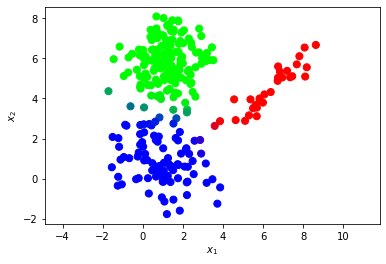

In [11]:
gamma = E_step(X, best_pi, best_mu, best_sigma)
labels = gamma.argmax(axis=1)
colors = np.array([(31, 119, 180), (255, 127, 14), (44, 160, 44)]) / 255.
fig, ax = plt.subplots(1, 1)
ax.scatter(X[:, 0], X[:, 1], c=gamma, s=50)
ax.axis('equal')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
plt.show()
fig.savefig('g_3_soft.png')

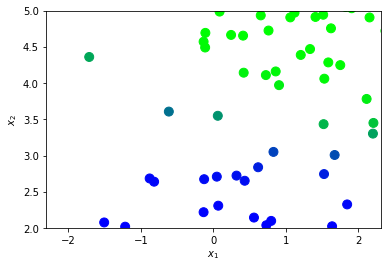

In [12]:
labels = gamma.argmax(axis=1)
colors = np.array([(31, 119, 180), (255, 127, 14), (44, 160, 44)]) / 255.
fig, ax = plt.subplots(1, 1)
ax.scatter(X[:, 0], X[:, 1], c=gamma, s=80)
ax.axis('equal')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_xlim((-2,2))
ax.set_ylim((2,5))
plt.show()
fig.savefig('g_3_1_soft.png')

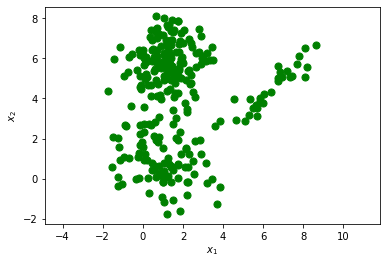

In [13]:
fig, ax = plt.subplots(1, 1)
ax.scatter(X[:, 0], X[:, 1], c='g', s=50)
ax.axis('equal')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
plt.show()
fig.savefig('g_3_empty.png')

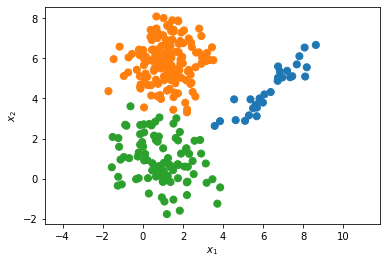

In [14]:

labels = gamma.argmax(axis=1)
colors = np.array([(31, 119, 180), (255, 127, 14), (44, 160, 44)]) / 255.
fig, ax = plt.subplots(1, 1)
ax.scatter(X[:, 0], X[:, 1], c=colors[labels], s=50)
ax.axis('equal')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
plt.show()
fig.savefig('g_3_hard.png')